# Import Libraries

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Read and plot the image

In [131]:
img = cv2.imread('1.tif')
print(img.shape)
n = img.shape[0]
m = img.shape[1]

(500, 500, 3)


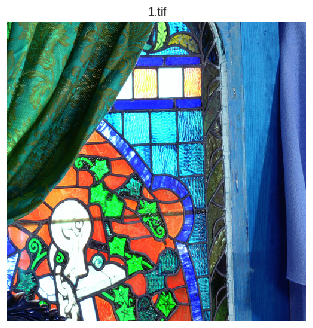

In [132]:
plt.imshow(img), plt.title('1.tif')
plt.xticks([]), plt.yticks([])
plt.show()

# Interpolate the image to double of its size

In [133]:
interpolated_img = np.zeros((2*n, 2*m, 3))
print(interpolated_img.shape)

(1000, 1000, 3)


In [0]:
for k in range(3):
    for i in range(n):
        for j in range(m):
            interpolated_img[2*i, 2*j, k] = img[i, j, k]

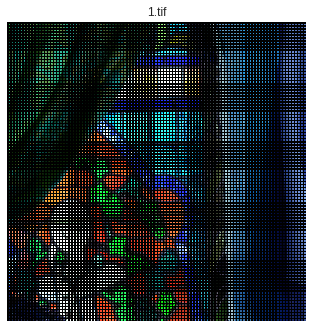

In [135]:
plt.imshow(interpolated_img.astype(np.uint8)), plt.title('1.tif')
plt.xticks([]), plt.yticks([])
plt.show()

# Apply bilateral filter to predict the missing pixels

In [0]:
# Function to convolve image with the given filter
def convolution(img, filter):
    n = img.shape[0]
    m = img.shape[1]
    f = filter.shape[0]
    s = int((f - 1)/2)
    output = np.zeros((n - s, m - s))
    for i in range(s, n - s):
        for j in range(s, m - s):
            output[i, j] = np.sum(np.multiply(img[i-s:i+s+1,j-s:j+s+1], filter))
    return output

In [0]:
# modified gaussian kernal which has weight only where image pixel is not exaclty 0
def gaussian_kernel(n, sigma, img):
    kernel = np.zeros((n, n))
    k = n//2
    for i in range(-k, k+1):
        for j in range(-k,k+1):
            if (img[i+k, j+k] != 0):
                kernel[i+k, j+k] = np.exp(-(i**2 + j**2)/(2.0*sigma**2))/(2*np.pi*sigma**2)
    return kernel/kernel.sum()
img_diag_neighbors = np.array(([1, 0, 2], [0, 3, 0], [4, 0, 5]))
gaussian_kernel(3, 1, img_tmp)

def gaussian_kernel_diag_neighbours(n, sigma):
    img_diagonal = np.array(([1, 0, 1], [0, 1, 0], [1, 0, 1]))
    return gaussian_kernel(n, sigma, img_diagonal)

def gaussian_kernel_str_neighbours(n, sigma):
    img_str = np.array(([0, 1, 0], [1, 1, 1], [0, 1, 0]))
    return gaussian_kernel(n, sigma, img_str)


#### In case of bilateral filtering, the kernel also depends on the nearby pixel intensity values not just on the distance from the center pixel. So, kernel keeps on changing as it is convolved with the image.

In [0]:
# modified function to perform convolution of image with a bilateral filter
# only considers those pixels which have 4 diagonal neighbours available

def convolve_bilateral_diagonal(img, sigma):
    
    # first obtain the gaussian_kernel, sigma = 3.0
    g_kernel = gaussian_kernel_diag_neighbours(3, 3.0)
    
    n = img.shape[0]
    m = img.shape[1]
    f = g_kernel.shape[0]
    s = int((f - 1)/2)
    output = np.array(img)
        
    # filter to store pixel intensity square differences
    b_filter = np.zeros((f, f))
    for i in range(s, n - s, 2):
        for j in range(s, m - s, 2):
            # assume center pixel to be mean of neighbouring pixels which are available
            output[i, j] = (img[i - 1, j - 1] + img[i - 1, j + 1] + img[i + 1, j - 1] + img[i + 1, j + 1])/4
            # take pixel intensity differences and multiply with gaussian filter to obtain bilateral filter
            b_filter = np.exp(-((img[i-s:i+s+1, j-s:j+s+1] - output[i, j]))**2/(2*sigma**2))/(2*np.pi*sigma**2)
            filter = np.multiply(g_kernel, b_filter)
            filter = filter/np.sum(filter)
            output[i, j] = np.sum(np.multiply(img[i-s:i+s+1,j-s:j+s+1], filter))
    return output

def convolve_bilateral_str(img, sigma):
    
    g_kernal = gaussian_kernel_str_neighbours(3, 3.0)
    
    n = img.shape[0]
    m = img.shape[1]
    f = g_kernel.shape[0]
    s = int((f - 1)/2)
    output = np.array(img)
    
    b_filter = np.zeros((f, f))
    for i in range(s, n - s, 1):
        if (i % 2 == 0):
            k = s
        else:
            k = s+1
        for j in range(k, m - s, 2):
            output[i, j] = (img[i - 1, j] + img[i, j - 1] + img[i, j + 1] + img[i + 1, j])/4
            b_filter = np.exp(-((img[i-s:i+s+1, j-s:j+s+1] - output[i, j]))**2/(2*sigma**2))/(2*np.pi*sigma**2)
            filter = np.multiply(g_kernel, b_filter)
            filter = filter/np.sum(filter)
            output[i, j] = np.sum(np.multiply(img[i-s:i+s+1, j-s:j+s+1], filter))    
    return output

def convolve_bilateral_three_neighbours(img, sigma):
    
    g_kernel_top = gaussian_kernel(3, 3.0, np.array(([0, 0, 0], [1, 1, 1], [1, 1, 1])))
    g_kernel_left = gaussian_kernel(3, 3.0, np.array(([0, 1, 1], [0, 1, 1], [0, 1, 1])))
    g_kernel_right = gaussian_kernel(3, 3.0, np.array(([1, 1, 0], [1, 1, 0], [1, 1, 0])))

    n = img.shape[0]
    m = img.shape[1]
    f = g_kernel_top.shape[0]
    s = int((f - 1)/2)
    
    output = np.array(img)
    i = 0
    for j in range(s, m - s, 2):
        output[i, j] = np.sum(img[i:i+s+1, j-s:j+s+1])/6
        b_filter = np.exp(-((img[i:i+s+1, j-s:j+s+1] - output[i, j]))**2/(2*sigma**2))/(2*np.pi*sigma**2)
        filter = np.multiply(g_kernel_top[1:,:], b_filter)
        filter = filter/np.sum(filter)
        output[i, j] = np.sum(np.multiply(img[i:i+s+1, j-s:j+s+1], filter))
    
    j = 0
    for i in range(s, m - s, 2):
        output[i, j] = np.sum(img[i-s:i+s+1, j:j+s+1])/6
        b_filter = np.exp(-((img[i-s:i+s+1, j:j+s+1] - output[i, j]))**2/(2*sigma**2))/(2*np.pi*sigma**2)
        filter = np.multiply(g_kernel_left[:,1:], b_filter)
        filter = filter/np.sum(filter)
        output[i, j] = np.sum(np.multiply(img[i-s:i+s+1,j:j+s+1], filter))
    
    return output

def bilateral_interpolate(img, sigma):
    output = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
    for k in range(3):
        output[:,:,k] = convolve_bilateral_diagonal(img[:,:,k], sigma)
        output[:,:,k] = convolve_bilateral_str(output[:,:,k], sigma)
        output[:,:,k] = convolve_bilateral_three_neighbours(output[:,:,k], sigma)
    return output

In [0]:
filter_size = 3

# now apply bilateral filter to interpolate the image, sigma = 10.0
output = bilateral_interpolate(interpolated_img, 10.0)

In [0]:
# Function to plot the orignal and image obtained after applying the filter
def plot_org_and_filtered_images(org, filtered, filter_name):
    plt.subplot(121), plt.imshow(org.astype(np.uint8)), plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(filtered.astype(np.uint8)), plt.title(filter_name)
    plt.xticks([]), plt.yticks([])
    plt.show()

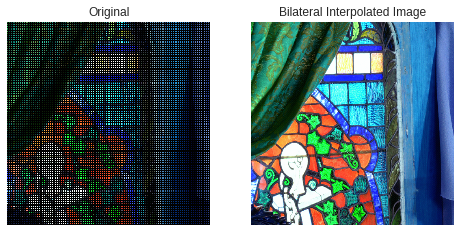

In [141]:
# plot the orignal and interpolated images
plot_org_and_filtered_images(interpolated_img, output, "Bilateral Interpolated Image")

In [142]:
# the no. of pixels remaining to be predicted
count = 0
for k in range(3):
    for i in range(2*n):
        for j in range(2*m):
            if(output[i, j, k] == 0.0):
                count = count + 1
print(count)

# only the last rows and last columns are now left

6172


In [143]:
# copy the 2nd last rows and 2nd last columns into the last rows and columns respectively
final_interpolated_img = output

for k in range(3):
    final_interpolated_img[2*n - 1, :, k] = final_interpolated_img[2*n - 2, :, k]
    final_interpolated_img[:, 2*m - 1, k] = final_interpolated_img[:, 2*m - 2, k]
    
count = 0
for i in range(2*n):
    for j in range(2*m):
        if(final_interpolated_img[i, j, k] == 0.0):
            count = count + 1
print(count)


33


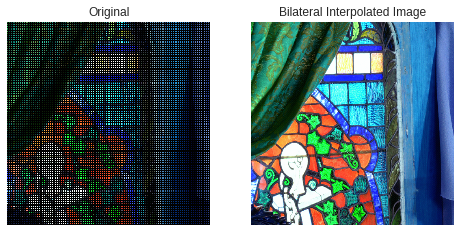

In [144]:
plot_org_and_filtered_images(interpolated_img, final_interpolated_img, "Bilateral Interpolated Image")